# Introduction

The objective is to develop a model that can predict the lifetime value of each customer, which helps to identify high-value customers for targeted marketing campaigns and personalized offerings.

The target is to reach 90% accuracy at predicting whether or not a customer is a high value customer or not.

# Preparing the Data

This is a transnational data set which contains all the transactions occurring between 2010/12/01 and rece for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The data can be found in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail)


In [1]:
# Load all required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno
from IPython.display import display, HTML
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Data Loading

| Column Name | Column Description                                                                                                                |
|----------------------|--------------------------------------------------|
| InvoiceNo   | a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation |
| StockCode   | a 5-digit integral number uniquely assigned to each distinct product                                                              |
| Description | product name                                                                                                                      |
| Quantity    | the quantities of each product (item) per transaction                                                                             |
| InvoiceDate | the day and time when each transaction was generated                                                                              |
| UnitPrice   | product price per unit in Pound Sterling                                                                                          |
| CustomerID  | a 5-digit integral number uniquely assigned to each customer                                                                      |
| Country     | the name of the country where each customer resides                                                                               |
|             |                                                                                                                                   |

Display the first 100 rows of the data.


In [2]:
retail_data = pd.read_excel("Online Retail.xlsx",
                            parse_dates = ["InvoiceDate"])
# Convert the fisrt 100 rows of data to HTML table using tabulate
table_html1 = tabulate(retail_data.head(100), 
                        headers = "keys", tablefmt = "html")
# Create the complete HTML with the table and css
html1 = f"""
<div style = "height: 600px; width: 1000px; overflow: auto; display: inline-block;">
    {table_html1}
</div>
"""
# Display the table
display(HTML(html1))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


## Data Processing

Visualize missing values, clean the data by removing invalid entries, and create a new column for the total price of each transaction item.


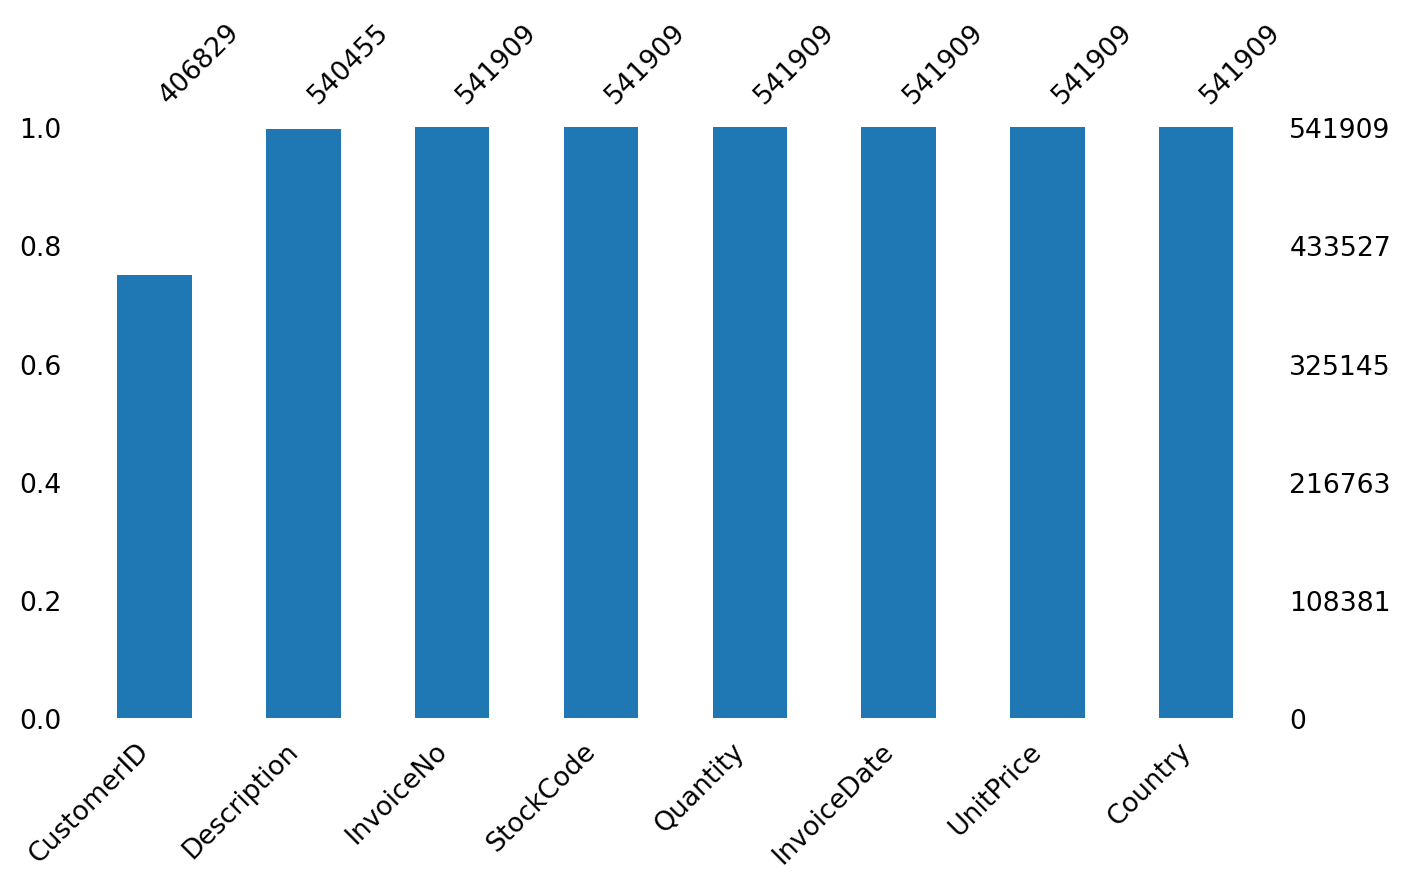

In [3]:
# Check missing values for each column of the data
# Plot the sum of each columns row that are non-null
msno.bar(
    retail_data,
    sort = "ascending",
    color = "#1f77b4",
    labels = True,
    figsize = (8, 4),
    fontsize = 10)
plt.show()

The data has 2 columns with missing values, namely `CustomerID` and `Description`. The `Description`column will be dropped because the unique `StockCode` could serve the same purpose of identifying each product, while rows with no `CustomerID` make it impossible to assign the transaction to any customer and therefore will also be dropped.


In [4]:
# Filter out rows with Negative or Zero Quantities
retail_clean = retail_data[retail_data["Quantity"] > 0]
# Filter out rows with Negative or Zero UnitPrice
retail_clean = retail_clean[retail_clean["UnitPrice"] > 0]
# Remove Description Column
retail_clean.drop(columns = ["Description"], inplace = True)
# Drop Rows with No CustomerIDs
retail_clean.dropna(subset = ["CustomerID"], inplace = True)
# Drop duplicate rows
retail_clean.drop_duplicates(inplace=True)
# Create Total_Price Column for items bought
retail_clean["TotalPrice"] = retail_clean["Quantity"] * retail_clean["UnitPrice"] 
# Check the structure of the cleaned data
print(tabulate(retail_clean.info(), 
              headers = "keys", tablefmt = "html"))

<class 'pandas.core.frame.DataFrame'>
Index: 392690 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392690 non-null  object        
 1   StockCode    392690 non-null  object        
 2   Quantity     392690 non-null  int64         
 3   InvoiceDate  392690 non-null  datetime64[ns]
 4   UnitPrice    392690 non-null  float64       
 5   CustomerID   392690 non-null  float64       
 6   Country      392690 non-null  object        
 7   TotalPrice   392690 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 27.0+ MB



Rows with negative `Quantity` and `UnitPrice` are filtered out because they indicate a return transaction. The data now contains no missing values, no description column, no duplicates and ready to be explored.

# Exploratory Data Analysis

## Data Distribution

Analyze the number of customers, stocked items, and purchases in the data.


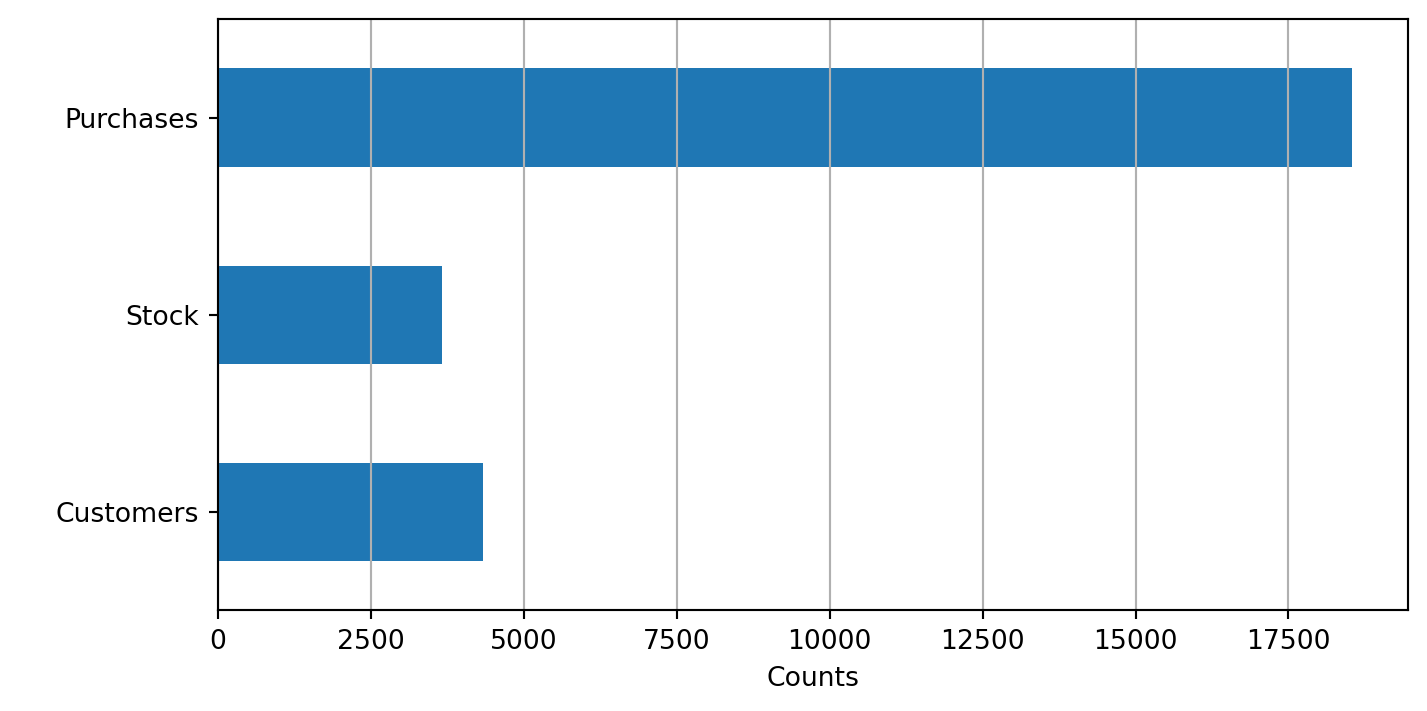

In [5]:
# Number of Customers, stocked items and purchases in the retail Data
count_cust = len(retail_clean["CustomerID"].value_counts())
count_stock = len(retail_clean["StockCode"].value_counts())
count_purchases = len(retail_clean["InvoiceNo"].value_counts())

counts_data = pd.DataFrame({" ": ["Customers", "Stock", "Purchases"],
                            "Counts": [count_cust, count_stock,
                            count_purchases]
                        })
# Set "Names" column as index
counts_data.set_index(" ", inplace = True)
# Set figure size
fig, ax = plt.subplots(figsize=(8, 4))
# Plot the counts data in a horizontal bar chart
counts_data.plot(kind = "barh", legend = None, ax = ax)
# Set axis labels
ax.set_xlabel("Counts")
ax.set_ylabel(" ")
ax.xaxis.grid(True)
# Show the plot
plt.show()

The number of purchases is high, which indicates the presence of customers that have made multiple purchases.

------------------------------------------------------------------------

## Country Statistics

Calculate and display statistics for each country, including the number of customers, purchases, total revenue, average revenue per customer, average purchase value, and purchase frequency.


In [6]:
country_cus = pd.DataFrame(retail_clean.groupby("Country")["CustomerID"].nunique().rename("No_of_Customers"))
country_pur = pd.DataFrame(retail_clean.groupby("Country")["InvoiceNo"].nunique().rename("NumPurchases"))
country_rev = pd.DataFrame(retail_clean.groupby("Country")["TotalPrice"].agg("sum").rename("TotalRevenue").round(2))
# Join all the dataframes above into 1
country_data = country_cus.merge(country_pur, 
                                  on = "Country").merge(country_rev, 
                                  on = "Country")
# Calculate Average revenue per customer for each country
country_data["Avg_Revenue_per_Customer"] = (country_data["TotalRevenue"] / country_data["No_of_Customers"]).round(2)
# Calculate Average purchase value each country
country_data["Avg_Purchase_Value"] = (country_data["TotalRevenue"] / country_data["NumPurchases"]).round(2)
# Calculate Purchase Frequency for each country
country_data["Purchase_Frequency"] = (country_data["NumPurchases"] / country_data["No_of_Customers"]).round(2)
# Print the country statistics data
# Convert the first 100 rows of country_data to HTML table using tabulate
table_html2 = tabulate(country_data.sort_values(["No_of_Customers", "NumPurchases"], ascending = False),
                        headers = "keys", tablefmt = "html")
# Create the complete HTML with the table and css
html2 = f"""
<div style = "height: 600px; width: 1000px; overflow: auto; display: inline-block;">
    {table_html2}
</div>
"""
# Display the table
display(HTML(html2))

Country,No_of_Customers,NumPurchases,TotalRevenue,Avg_Revenue_per_Customer,Avg_Purchase_Value,Purchase_Frequency
United Kingdom,3920,16646,7.28447e+06,1858.28,437.61,4.25
Germany,94,457,228678,2432.75,500.39,4.86
France,87,389,208934,2401.54,537.11,4.47
Spain,30,90,61558.6,2051.95,683.98,3
Belgium,25,98,41196.3,1647.85,420.37,3.92
Switzerland,21,51,56443.9,2687.81,1106.74,2.43
Portugal,19,57,33375.8,1756.62,585.54,3
Italy,14,38,17483.2,1248.8,460.09,2.71
Finland,12,41,22546.1,1878.84,549.9,3.42
Austria,11,17,10198.7,927.15,599.92,1.55


United Kingdom, Germany and France are the top 3 countries with the highest number of customers, purchases and revenue. Of note is `EIRE` which has only 3 customers but a large number of purchases and revenue.

------------------------------------------------------------------------

## Stock Statistics

Check the Stock items with the highest revenue and number of purchases


In [7]:
stock_data = retail_clean.groupby("StockCode").agg({"TotalPrice": "sum", "Quantity": "sum"}).sort_values(["TotalPrice", "Quantity"], ascending = False)
# Print the stock_stats
# Convert the first 50 rows of stock_data to HTML table using tabulate
table_html3 = tabulate(stock_data.head(50),
                        headers = "keys", tablefmt = "html")
# Create the complete HTML with the table and css
html3 = f"""
<div style = "height: 600px; width: 1000px; overflow: auto; display: inline-block;">
    {table_html3}
</div>
"""
# Display the table
display(HTML(html3))

StockCode,TotalPrice,Quantity
23843,168470,80995
22423,142265,12374
85123A,100547,36763
85099B,85040.5,46078
23166,81416.7,77916
POST,77804,3120
47566,68785.2,15279
84879,56413,35263
M,53419.9,6933
23084,51251.2,27153


A list of the top 50 stock items with the highest revenue and number of times each was purchased in the data.

------------------------------------------------------------------------

## Customer Statistics

Calculate and display customer statistics, including total spending, number of purchases, average purchase value, and the country of each customer.


In [8]:
# Group by Customer to calculate total spending and number of purchases
customer_data = retail_clean.groupby("CustomerID").agg({"TotalPrice": "sum", "InvoiceNo": "nunique"})
# Rename the columns created above
customer_data.rename(columns={"Total_Purchase_Value": "TotalPrice", "InvoiceNo": "NumPurchases"}, inplace=True)
# Calculate the average revenue per customer
customer_data["AvgPurchaseValue"] = (customer_data["TotalPrice"] / customer_data["NumPurchases"]).round(2)
# Add Country data for each customer
customer_country = retail_clean[["CustomerID", "Country"]].drop_duplicates()
customer_data = customer_country.merge(customer_data, on = "CustomerID", 
                                        how = "left")
# Print the customer_data
# Convert the first 100 rows of customer_data to HTML table using tabulate
table_html4 = tabulate(customer_data.head(100).sort_values(["TotalPrice", "NumPurchases", "AvgPurchaseValue"], ascending = False),
                        headers = "keys", tablefmt = "html")
# Create the complete HTML with the table and css
html4 = f"""
<div style = "height: 600px; width: 1000px; overflow: auto; display: inline-block;">
    {table_html4}
</div>
"""
# Display the table
display(HTML(html4))

,CustomerID,Country,TotalPrice,NumPurchases,AvgPurchaseValue
65,14911,EIRE,143711,201,714.98
15,17511,United Kingdom,91062.4,31,2937.5
12,16029,United Kingdom,80850.8,63,1283.35
35,13694,United Kingdom,65039.6,50,1300.79
8,15311,United Kingdom,60632.8,91,666.29
69,17841,United Kingdom,40519.8,124,326.77
46,12748,United Kingdom,33053.2,209,158.15
18,13408,United Kingdom,28117,62,453.5
82,13777,United Kingdom,25977.2,33,787.19
39,16210,United Kingdom,21086.3,18,1171.46


The Customer with the highest number of purchases and total spending is from `EIRE`.

------------------------------------------------------------------------

## Calculate CLV

Create `FirstPurchase` by finding the earliest purchase date and `LastPurchase` as the latest purchase date of a customer.

Create `LifeSpan` by subtracting customer's `FirstPurchase` date from customer's `LastPurchase` and divide by 365 to get a yearly figure.

Create `AvgPurchaseValue` by dividing number of purchases of customer with customer's `LifeSpan`.

Calculate CLV for each customer using `AvgPurchaseValue` * `YearlyPurchases`, and display the resulting data.


In [9]:
# Calculate first and last purchase date for each customer
purchase_period = retail_clean.groupby("CustomerID").agg({"InvoiceDate": ["min", "max"]}).reset_index()
# Rename the columns
purchase_period.columns =["CustomerID", "FirstPurchase", "LastPurchase"]
# Combine customer_date with purchase_period
customer_data = customer_data.merge(purchase_period, on = "CustomerID")
# Calculate the purchasing period in days for each customer and convert to yearly fraction
customer_data["LifeSpan"] = (((customer_data["LastPurchase"] - customer_data["FirstPurchase"]).dt.days)/365).round(2)
# Calculate number of purchases per year for each customer
customer_data["YearlyPurchases"] = (customer_data["NumPurchases"] / customer_data["LifeSpan"]).round(2)
# Replace infinite values in YearlyPurchases column with Zero
customer_data["YearlyPurchases"] = customer_data["YearlyPurchases"].replace(np.inf, 0)
# Calculate CLV for each customer as AvgPurchaseValue * YearlyPurchases
customer_data["CLV"] = (customer_data["AvgPurchaseValue"] * customer_data["YearlyPurchases"]).round(2)
# Print customer_data
# Convert the first 100 rows of customer_data to HTML table using tabulate
table_html4 = tabulate(customer_data.head(100).sort_values(["TotalPrice", "NumPurchases", "AvgPurchaseValue", "LifeSpan", "YearlyPurchases", "CLV"], ascending = False),
                        headers = "keys", tablefmt = "html")
# Create the complete HTML with the table and css
html4 = f"""
<div style = "height: 600px; width: 1000px; overflow: auto; display: inline-block;">
    {table_html4}
</div>
"""
# Display the table
display(HTML(html4))

,CustomerID,Country,TotalPrice,NumPurchases,AvgPurchaseValue,FirstPurchase,LastPurchase,LifeSpan,YearlyPurchases,CLV
65,14911,EIRE,143711,201,714.98,2010-12-01 14:05:00,2011-12-08 15:54:00,1.02,197.06,140894
15,17511,United Kingdom,91062.4,31,2937.5,2010-12-01 10:19:00,2011-12-07 10:12:00,1.01,30.69,90151.9
12,16029,United Kingdom,80850.8,63,1283.35,2010-12-01 09:57:00,2011-11-01 10:27:00,0.92,68.48,87883.8
35,13694,United Kingdom,65039.6,50,1300.79,2010-12-01 12:12:00,2011-12-06 09:32:00,1.01,49.5,64389.1
8,15311,United Kingdom,60632.8,91,666.29,2010-12-01 09:41:00,2011-12-09 12:00:00,1.02,89.22,59446.4
69,17841,United Kingdom,40519.8,124,326.77,2010-12-01 14:41:00,2011-12-08 12:07:00,1.02,121.57,39725.4
46,12748,United Kingdom,33053.2,209,158.15,2010-12-01 12:48:00,2011-12-09 12:20:00,1.02,204.9,32404.9
18,13408,United Kingdom,28117,62,453.5,2010-12-01 10:39:00,2011-12-08 09:05:00,1.02,60.78,27563.7
82,13777,United Kingdom,25977.2,33,787.19,2010-12-01 16:01:00,2011-12-09 12:25:00,1.02,32.35,25465.6
39,16210,United Kingdom,21086.3,18,1171.46,2010-12-01 12:27:00,2011-12-08 12:36:00,1.02,17.65,20676.3


Not surprising that the Customer with the highest number of purchases and total spending is from `EIRE`, and also has the highest CLV value.

## Correlation

Show a correlation heat map of the data after dropping the `CustomerID`, `Country`, `FirstPurchase` and `LastPurchase` columns.


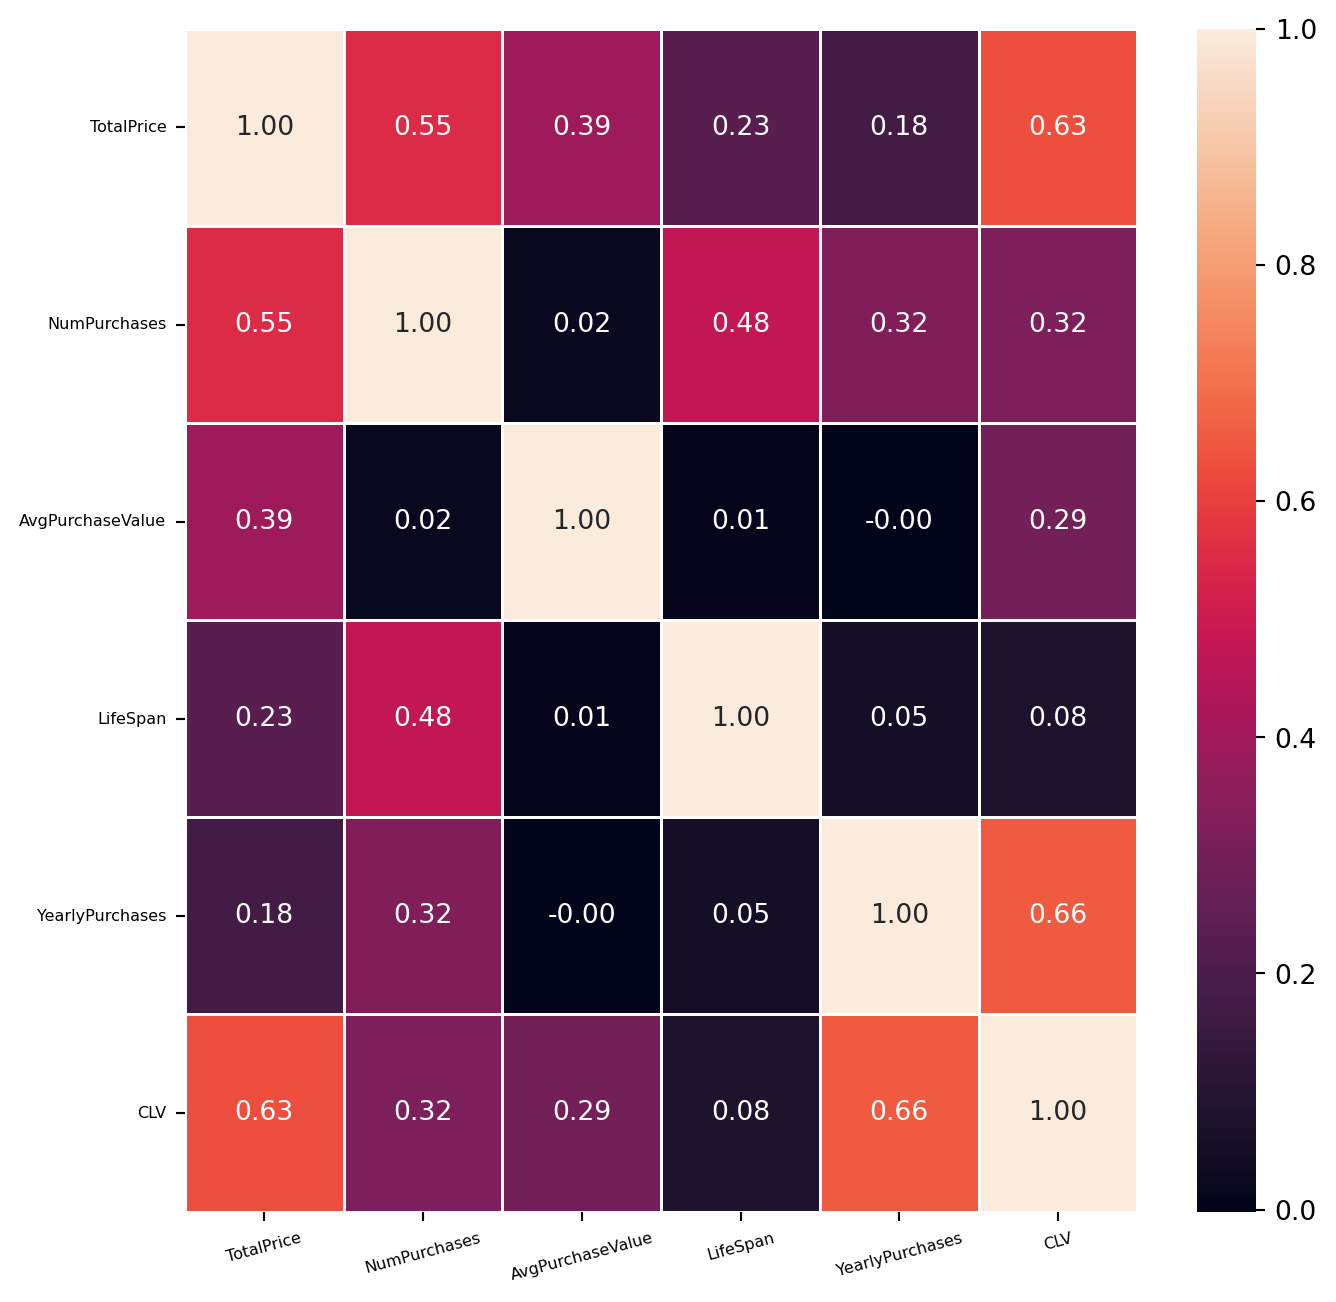

In [10]:
# Drop the CustomerID, Country, FirstPurchase and LastPurchase columns
customer_data.drop(columns = ["FirstPurchase", "LastPurchase", 
                            "CustomerID", "Country"], inplace = True)
plt.figure(figsize=(8, 8))
sns.heatmap(customer_data.corr(), annot = True, 
            linewidths = 0.5, fmt = ".2f");
plt.xticks(rotation = 15, fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()

We can see a mild linear positive relationship between `CLV` and 2 independent features `YearlyPurchases` and `TotalPrice`.

# Predictive Modeling

## Train/Test split

Split the data into training and testing sets. 


In [11]:
# Set X as the data without the target column, while y is only the target
X = customer_data.drop(columns = ["CLV"]).values
y = customer_data["CLV"].values
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                              test_size = 0.3,
                                              random_state = 42)

70% of the data will be used to train the models, while the remaining 30% is to test the accuracy of the models.

# Model Training and Evaluation

3 models to be tried to choose the best amongst with the highest accuracy in predicting Customer Lifetime Value.

## Linear Regression Model

Train a Linear Regression model and evaluate its performance using metrics such as RMSE, MAE, and R-squared.


In [12]:
# Initialize Linear Regression model
reg = LinearRegression()
# Train model
reg.fit(X_train, y_train)
# Predict using model
reg_y_pred = reg.predict(X_test)
# Evaluate model
reg_accuracy = r2_score(y_test, reg_y_pred).round(2)
req_mse = root_mean_squared_error(y_test, reg_y_pred).round(2)
reg_mae = mean_absolute_error(y_test, reg_y_pred).round(2)
# Print model metrics
print(f'Linear Regression - Accuracy: {reg_accuracy * 100}%, RMSE: {req_mse}, MAE: {reg_mae}')

Linear Regression - Accuracy: 43.0%, RMSE: 6023.02, MAE: 1848.17


A 43% accuracy for the Linear Regression model makes it a poor choice of model for this task.

------------------------------------------------------------------------

## Random Forests Model

Train a Random Forest Regressor model, use grid search for hyperparameter tuning, and evaluate its performance using metrics such as RMSE, MAE, and R-squared.


In [13]:
# Initialize RF model
rf_model = RandomForestRegressor(n_estimators = 500, 
                                  max_depth = 4,
                                  min_samples_split = 4,
                                  max_features = None,
                                  bootstrap = True,
                                  criterion = 'friedman_mse',
                                  random_state = 42)
# Train model
rf_model.fit(X_train, y_train)
# Predict using model
rf_y_pred = rf_model.predict(X_test)
# Evaluate model
rf_accuracy = r2_score(y_test, rf_y_pred).round(2)
rf_mse = mean_squared_error(y_test, rf_y_pred).round(2)
# Print model metrics
print(f'Random Forest - Accuracy: {rf_accuracy * 100}%, MSE: {rf_mse}')

Random Forest - Accuracy: 79.0%, MSE: 13442644.69


A 79% accuracy score for Random Forests model is very acceptable.

------------------------------------------------------------------------

## XGBoost Model

Train an XGBoost Regressor model, use randomized search for hyperparameter tuning, and evaluate its performance using metrics such as RMSE, MAE, and R-squared.


In [14]:
# Initialize XGB model
xgb_model = xgb.XGBRegressor(objective = "reg:squarederror",
                        n_estimators = 500,
                        learning_rate = 0.2,
                        max_depth = 4,
                        subsample = 0.7,
                        seed = 1234)
# Train model
xgb_model.fit(X_train, y_train)
# Predict using model
xgb_y_pred = xgb_model.predict(X_test)
# Evaluate model
xgb_accuracy = r2_score(y_test, xgb_y_pred).round(2)
xgb_mse = mean_squared_error(y_test, xgb_y_pred).round(2)
# Print model metrics
print(f'XGB Regressor - Accuracy: {xgb_accuracy * 100}%, MSE: {xgb_mse}')

XGB Regressor - Accuracy: 89.0%, MSE: 7253746.93


An 80% score in accuracy for the XGBoost Regressor model is impressive.

After analyzing and modeling the customer lifetime value, the XGBoost Regressor Model performed the best based on RMSE, MAE, and R-squared metrics.

# Tuning Models

Lets try improving the Random Forest Regressor Model and the XGBoost Regressor Model using parameter tuning.

## Random Forest Model

Tune the Random Forest Regressor model using grid search and evaluate its performance.


In [15]:
# Define parameter grid
param_grid_rf = {
    "n_estimators": [100, 200, 300, 400],
    "max_features": [None, "sqrt", "log2"],
    "max_depth": [1, 2, 3, None],
    "min_samples_split": [2, 3, 5, 6]}
# Initialize Random Forest model
rf_model_tune = RandomForestRegressor(random_state = 42)
# Perform Grid Search on model
grid_search_rf = GridSearchCV(estimator = rf_model_tune, 
                              param_grid = param_grid_rf,
                              # Perform Cross-Validation
                              cv = 5,
                              # Utilize all the CPU cores available
                              n_jobs = -1,
                              # Show no info about grid search
                              verbose = 0)
grid_search_rf.fit(X_train, y_train)
# Best parameters and model evaluation
best_rf = grid_search_rf.best_estimator_
y_pred_rf_tune = best_rf.predict(X_test)
# Evaluate metrics of best model selected
mse_rf_tune = mean_squared_error(y_test, y_pred_rf_tune).round(2)
r2_rf_tune = r2_score(y_test, y_pred_rf_tune).round(2)
# Print model selected metrics
print(f"Best Random Forest Parameters:")
print(f"{grid_search_rf.best_params_}")
print(f"Random Forest - Accuracy: {r2_rf_tune * 100}%, MSE: {mse_rf_tune}")

Best Random Forest Parameters:
{'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Accuracy: 89.0%, MSE: 6780202.55


The Random Forest Regressor model has been improved from an accuracy score of 79% to 90% using `Grid Search` parameter tuning.

------------------------------------------------------------------------

## XGBoost Model

Tune the XGBoost Regressor model using randomized search and evaluate its performance.


In [16]:
# Define parameter grid
param_grid_xgb = {
    "n_estimators": [100, 200, 300, 400],
	"learning_rate": [0.1, 0.3, 0.4, 0.5],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.5, 0.6, 0.8, 0.9]}
# Initialize XGBoost model
xgb_model_tune = xgb.XGBRegressor(objective = "reg:squarederror", 
                              random_state = 42)
# Perform Randomized Search model
random_search_xgb = RandomizedSearchCV(estimator = xgb_model_tune,
                                      param_distributions = param_grid_xgb,
                                      # Number to sample and evaluate
                                      n_iter = 50,
                                      # Perform Cross-Validation
                                      cv = 5,
                                      # Utilize all CPU cores available
                                      n_jobs = -1,
                                      # Show no info about grid search
                                      verbose = 0, 
                                      random_state = 42)
random_search_xgb.fit(X_train, y_train)
# Best parameters and model evaluation
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb_tune = best_xgb.predict(X_test)
# Evaluate metrics of best model selected
mse_xgb_tune = mean_squared_error(y_test, y_pred_xgb_tune).round(2)
r2_xgb_tune = r2_score(y_test, y_pred_xgb_tune).round(2)
# Print model selected metrics
print(f"Best XGBoost Parameters:")
print(f"{random_search_xgb.best_params_}")
print(f"XGBoost - Accuracy: {r2_xgb_tune * 100}%, MSE: {mse_xgb_tune}")

Best XGBoost Parameters:
{'subsample': 0.6, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1}
XGBoost - Accuracy: 86.0%, MSE: 9097071.49


The XGBoost Regressor model has been improved from an accuracy score of 80% to 86% using `Random Search`parameter tuning.

# Feature Importance

Which features of a customers transaction contribute most to a model predicting whether the customer is high value or not? Each model finds patterns in data differently, so each model judges features importance differently.

## Random Forest Model


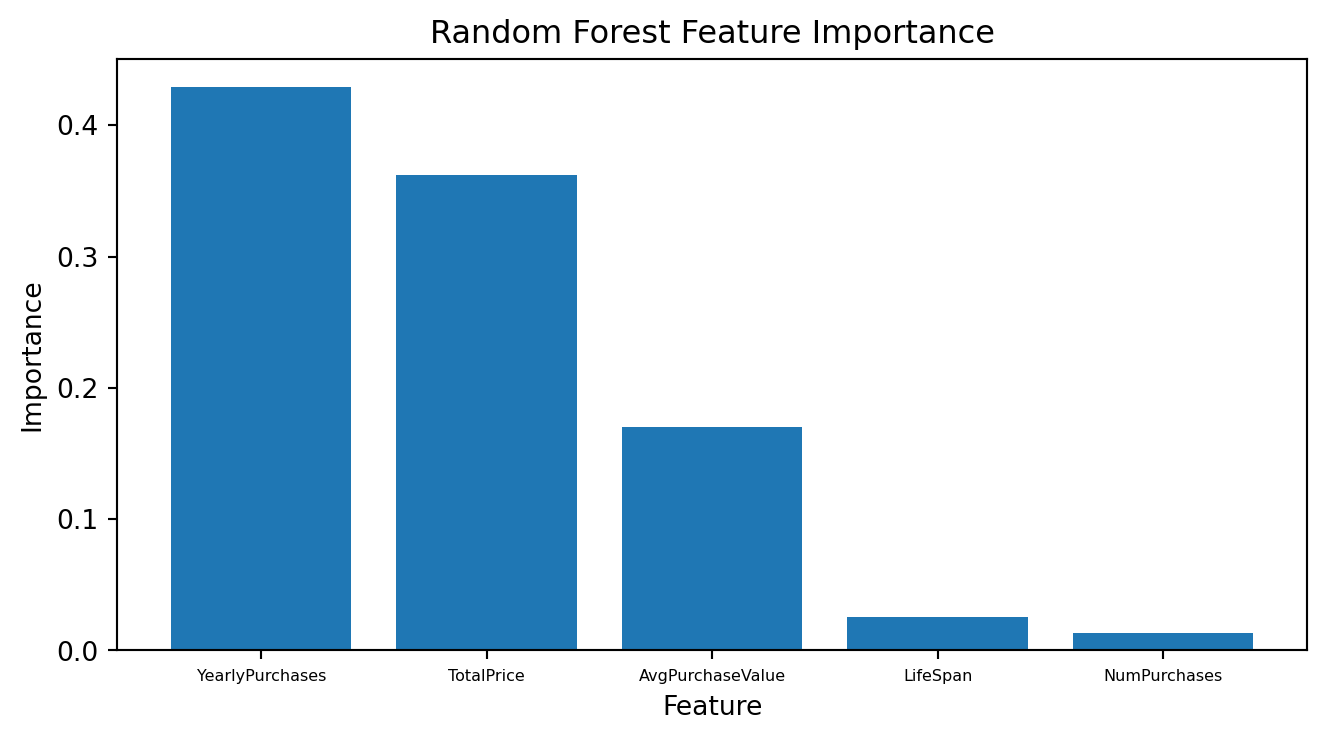

In [17]:
# Extract feature importance from the best RF model
rf_importances = best_rf.feature_importances_
# Create a dataframe for feature importance
rf_features = pd.DataFrame({
    'Feature': customer_data.drop(columns=['CLV']).columns,
    'Importance': rf_importances
})
# Sort the dataframe by importance
rf_features.sort_values(by='Importance', ascending=False, inplace=True)
# Plot the feature importance
plt.figure(figsize=(8, 4))
plt.bar(rf_features['Feature'], rf_features['Importance'])
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(fontsize = 6)
plt.title('Random Forest Feature Importance')
plt.show()

## XGBoost Model


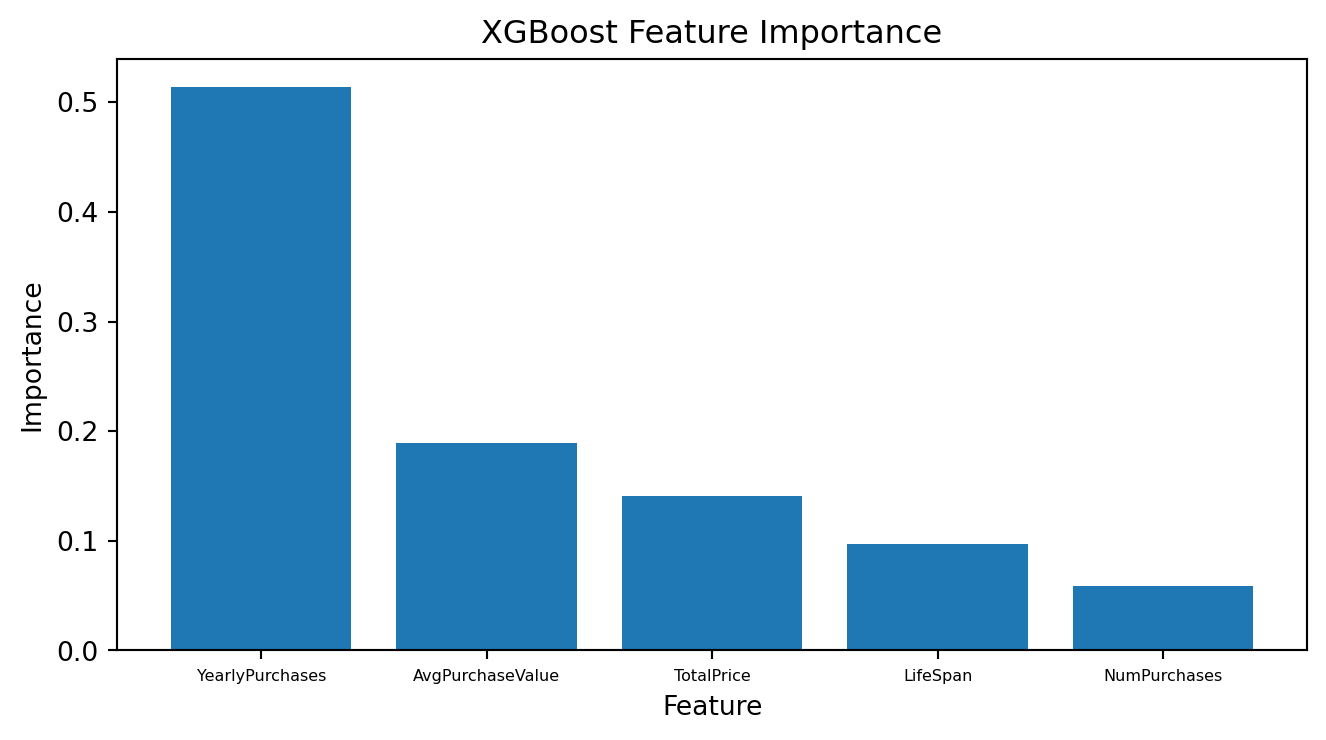

In [18]:
# Extract feature importance from the best XGBoost model
xgb_importances = best_xgb.feature_importances_
# Create a dataframe for feature importance
xgb_features = pd.DataFrame({
    'Feature': customer_data.drop(columns=['CLV']).columns,
    'Importance': xgb_importances
})
# Sort the dataframe by importance
xgb_features.sort_values(by='Importance', ascending=False, inplace=True)
# Plot the feature importance
plt.figure(figsize=(8, 4))
plt.bar(xgb_features['Feature'], xgb_features['Importance'])
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(fontsize = 6)
plt.title('XGBoost Feature Importance')
plt.show()

We can see for both models, the 3 most important features are `YearlyPurchases`, `AvgPurchaseValue` and `TotalPrice`, though the ranking differs for the 2 models.

# Conclusion

After tuning, the Random Forest Regressor Model was improved to predict the CLV of customers with an accuracy of 90%, and the XGBoost Regressor Model was improved to predict the CLV of customers with an accuracy of 86%. The Random Forest Regressor Model can be used to predict the CLV of customers, allowing businesses to target high-value customers more effectively and allocate resources efficiently.

[Link to Github](https://github.com/alatiku/Predict_Customer_Lifetime_Value "This link will take you to the github page hosting the files for this project")